In [7]:
# Cell 1: Install all dependencies
!pip install torch torchvision torchaudio
!pip install opencv-python numpy pillow matplotlib scikit-learn scipy
!pip install git+https://github.com/facebookresearch/segment-anything-2.git

Python(60500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(60528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(60529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Cloning https://github.com/facebookresearch/segment-anything-2.git to /private/var/folders/r7/vdpmjwm55fl4_ys4dmdzv2jc0000gn/T/pip-req-build-cnhkhhul
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /private/var/folders/r7/vdpmjwm55fl4_ys4dmdzv2jc0000gn/T/pip-req-build-cnhkhhul
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [8]:
# Cell 2: Download SAM2 model checkpoint (run once)
#!mkdir -p checkpoints
!curl -L -o checkpoints/sam2_hiera_small.pt https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
!curl -L -o sam2_hiera_s.yaml https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/sam2/configs/sam2/sam2_hiera_s.yaml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Python(60707) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100  175M  100  175M    0     0  29.1M      0  0:00:06  0:00:06 --:--:-- 31.6M:05  0:00:04  0:00:01 29.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Python(60784) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100  3659  100  3659    0     0  10948      0 --:--:-- --:--:-- --:--:-- 10987


In [9]:
# Cell 3: Verify installation
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

print("✓ All packages imported successfully!")
print(f"PyTorch: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'MPS' if torch.backends.mps.is_available() else 'CPU'}")

✓ All packages imported successfully!
PyTorch: 2.9.1
Device: MPS


Using device: mps


Using cache found in /Users/declanclowry/.cache/torch/hub/facebookresearch_dinov2_main


ENHANCED IKEA PART DETECTION

[1/6] Loading instruction page...

[2/6] Generating masks (with merging for instruction page)...


/Users/declanclowry/meta-hackathon-2025/.venv/lib/python3.13/site-packages/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/Users/declanclowry/meta-hackathon-2025/.venv/lib/python3.13/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


Generated 13 masks (after filtering & merging)

[3/6] Interactive mask labeling...


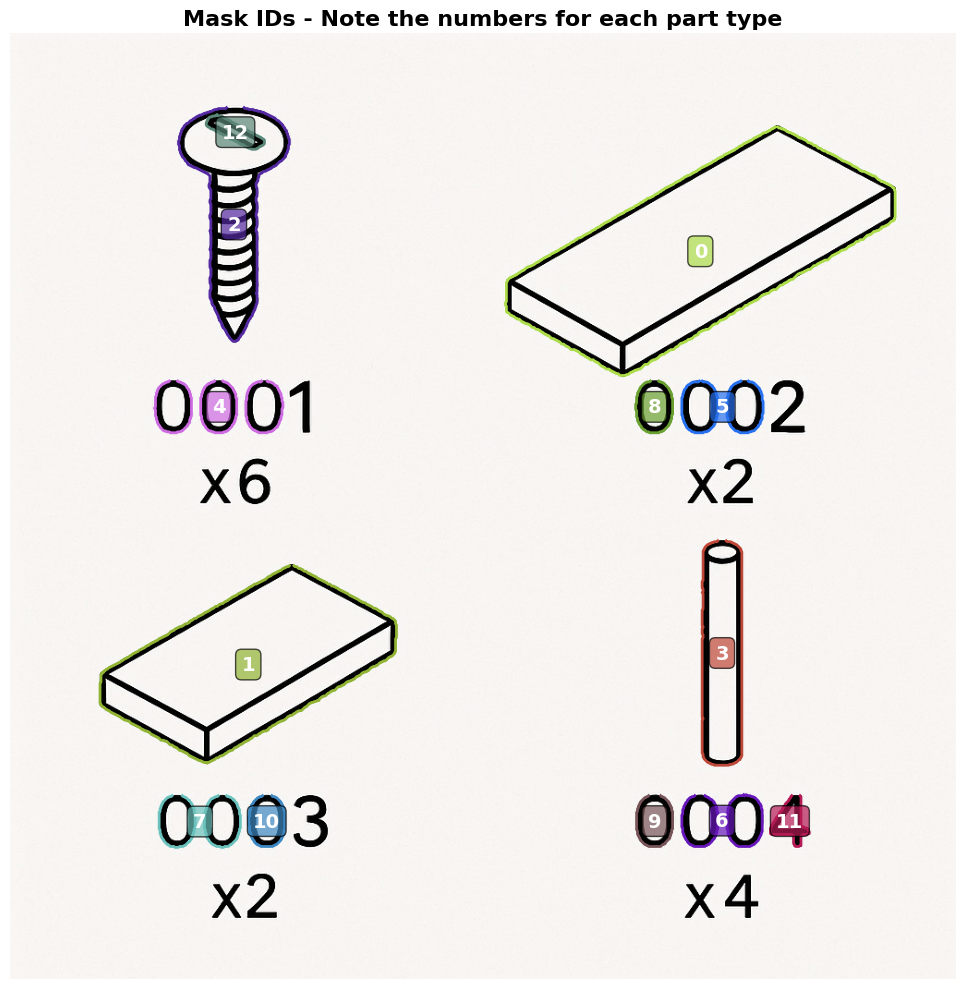


=== Interactive Mask Labeling ===
Instructions:
  - Look at the overlay image and note mask IDs
  - Enter label name and mask IDs (comma-separated)
  - Example: 'screw: 0, 1, 5' (if screw appears in masks 0, 1, and 5)
  - Type 'done' when finished
  - Type 'show' to see overlay again

✓ Added label 'plank' for masks: [0]

[4/6] Building reference embeddings...
Built reference for 'plank' from 4 views

[5/6] Creating smart detector...
Detector initialized with 1 part types
Thresholds: similarity=0.35, margin=0.05

[6/6] Processing scene...
Generated 18 masks in scene

Detection Summary:
  plank: 10 detected (avg confidence: 0.45)

[7/6] Visualizing results...


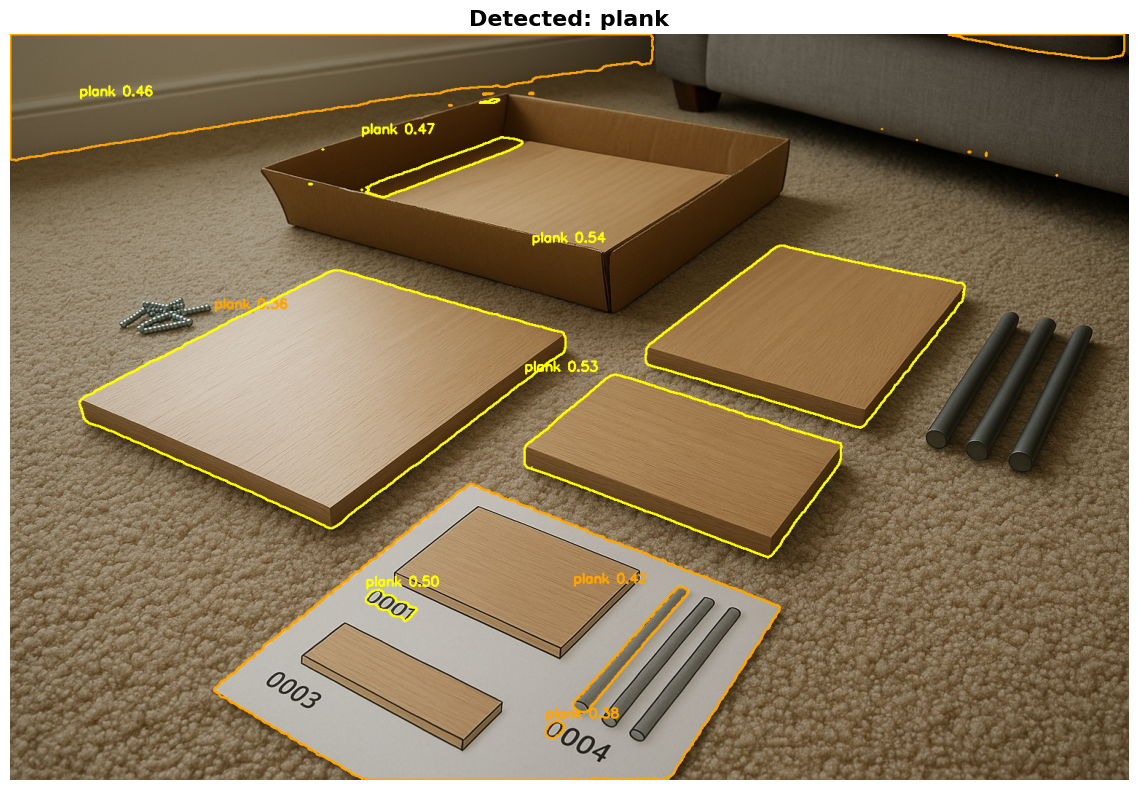


COMPLETE!


In [10]:
"""
Enhanced IKEA Part Detection - Better Mask Generation & Labeling

Key improvements:
1. Mask merging - Combine overlapping/nearby masks of same part
2. Smart mask filtering - Remove tiny fragments and background
3. Interactive labeling - Better UI for selecting masks
4. Confidence-based detection - Filter false positives
5. Multi-view references - Use multiple examples per part
"""

import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from collections import defaultdict

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import torchvision.transforms as T
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist


# === CONFIGURATION ===

device = torch.device("cuda" if torch.cuda.is_available() else 
                     "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


# === IMPROVED MASK GENERATION ===

def build_smart_mask_generator(model_size='small', quality='balanced'):
    """
    Build mask generator with quality presets.
    
    Args:
        model_size: 'small', 'large'
        quality: 'fast', 'balanced', 'high'
    """
    if model_size == 'small':
        config = "sam2_hiera_s.yaml"
        checkpoint = "checkpoints/sam2_hiera_small.pt"
    else:
        config = "sam2_hiera_l.yaml"
        checkpoint = "checkpoints/sam2_hiera_large.pt"
    
    sam2 = build_sam2(config, checkpoint, device=device)
    
    # Quality presets
    presets = {
        'fast': {
            'points_per_side': 16,
            'pred_iou_thresh': 0.75,
            'stability_score_thresh': 0.85,
            'crop_n_layers': 0,
            'min_mask_region_area': 200,
        },
        'balanced': {
            'points_per_side': 24,
            'pred_iou_thresh': 0.86,
            'stability_score_thresh': 0.90,
            'crop_n_layers': 0,
            'min_mask_region_area': 100,
        },
        'high': {
            'points_per_side': 32,
            'pred_iou_thresh': 0.88,
            'stability_score_thresh': 0.92,
            'crop_n_layers': 1,
            'crop_n_points_downscale_factor': 2,
            'min_mask_region_area': 50,
        }
    }
    
    params = presets[quality]
    
    return SAM2AutomaticMaskGenerator(sam2, **params)


# === MASK FILTERING & MERGING ===

def calculate_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """Calculate Intersection over Union between two masks"""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0


def calculate_bbox_distance(bbox1: Tuple, bbox2: Tuple) -> float:
    """Calculate distance between bbox centers"""
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    
    center1 = np.array([x1 + w1/2, y1 + h1/2])
    center2 = np.array([x2 + w2/2, y2 + h2/2])
    
    return np.linalg.norm(center1 - center2)


def merge_masks(masks: List[dict], iou_threshold: float = 0.1, 
                distance_threshold: float = 50) -> List[dict]:
    """
    Merge overlapping or nearby masks that likely belong to same object.
    
    This is crucial for instruction diagrams where parts may be split.
    """
    if not masks:
        return []
    
    # Sort by area (largest first)
    masks = sorted(masks, key=lambda x: x['area'], reverse=True)
    
    merged = []
    used = set()
    
    for i, mask_i in enumerate(masks):
        if i in used:
            continue
        
        # Start a group with this mask
        group = [mask_i]
        group_indices = {i}
        
        # Find masks to merge with this one
        for j, mask_j in enumerate(masks):
            if j <= i or j in used:
                continue
            
            # Check if masks should be merged
            iou = calculate_iou(mask_i['segmentation'], mask_j['segmentation'])
            distance = calculate_bbox_distance(mask_i['bbox'], mask_j['bbox'])
            
            # Merge if overlapping or very close
            if iou > iou_threshold or distance < distance_threshold:
                group.append(mask_j)
                group_indices.add(j)
        
        # Merge the group into a single mask
        if len(group) == 1:
            merged.append(mask_i)
        else:
            merged_mask = merge_mask_group(group)
            merged.append(merged_mask)
        
        used.update(group_indices)
    
    return merged


def merge_mask_group(masks: List[dict]) -> dict:
    """Merge a group of masks into one"""
    # Combine all segmentations
    combined_seg = np.zeros_like(masks[0]['segmentation'], dtype=bool)
    for m in masks:
        combined_seg = np.logical_or(combined_seg, m['segmentation'])
    
    # Calculate new bbox
    ys, xs = np.where(combined_seg)
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    
    return {
        'segmentation': combined_seg,
        'bbox': (x_min, y_min, x_max - x_min, y_max - y_min),
        'area': combined_seg.sum(),
        'predicted_iou': np.mean([m['predicted_iou'] for m in masks]),
        'stability_score': np.mean([m['stability_score'] for m in masks]),
    }


def filter_instruction_page_masks(masks: List[dict], 
                                  image_shape: Tuple[int, int],
                                  min_area_ratio: float = 0.001,
                                  max_area_ratio: float = 0.3) -> List[dict]:
    """
    Filter masks specifically for instruction pages.
    
    Removes:
    - Tiny fragments
    - Huge background regions
    - Masks on image edges (likely page borders)
    """
    h, w = image_shape[:2]
    total_area = h * w
    
    filtered = []
    
    for m in masks:
        area = m['area']
        x, y, bw, bh = m['bbox']
        
        # Area filters
        area_ratio = area / total_area
        if area_ratio < min_area_ratio or area_ratio > max_area_ratio:
            continue
        
        # Edge filter (remove masks touching edges)
        margin = 10
        if (x < margin or y < margin or 
            x + bw > w - margin or y + bh > h - margin):
            continue
        
        # Aspect ratio filter (remove very thin lines)
        aspect_ratio = bw / bh if bh > 0 else 0
        if aspect_ratio < 0.1 or aspect_ratio > 10:
            continue
        
        filtered.append(m)
    
    return filtered


def generate_smart_masks(image: np.ndarray, 
                        for_instruction_page: bool = False,
                        merge_nearby: bool = True) -> List[dict]:
    """
    Generate masks with smart filtering and merging.
    """
    # Use appropriate mask generator
    quality = 'high' if for_instruction_page else 'balanced'
    mask_gen = build_smart_mask_generator('small', quality)
    
    # Generate masks
    masks = mask_gen.generate(image)
    
    # Filter
    if for_instruction_page:
        masks = filter_instruction_page_masks(masks, image.shape)
    
    # Merge nearby masks
    if merge_nearby:
        masks = merge_masks(masks)
    
    # Sort by area
    masks = sorted(masks, key=lambda x: x['area'], reverse=True)
    
    return masks


# === INTERACTIVE MASK LABELING ===

class InteractiveMaskLabeler:
    """
    Interactive tool for labeling masks on instruction pages.
    
    Features:
    - Visual mask overlay with IDs
    - Click to select masks
    - Group selection for multi-part objects
    - Undo/redo support
    """
    
    def __init__(self, image: np.ndarray, masks: List[dict]):
        self.image = image
        self.masks = masks
        self.labels = {}  # {label: [mask_indices]}
        self.current_label = None
        
    def show_interactive_overlay(self, max_masks: int = 50):
        """Display masks with interactive selection"""
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.imshow(self.image)
        
        # Draw masks with IDs
        for idx, m in enumerate(self.masks[:max_masks]):
            # Create colored overlay
            mask = m['segmentation']
            color = np.random.rand(3)
            
            # Show mask boundary
            contours, _ = cv2.findContours(
                mask.astype(np.uint8), 
                cv2.RETR_EXTERNAL, 
                cv2.CHAIN_APPROX_SIMPLE
            )
            
            for cnt in contours:
                cnt = cnt.squeeze()
                if len(cnt.shape) == 2:
                    ax.plot(cnt[:, 0], cnt[:, 1], color=color, linewidth=2)
            
            # Add ID label
            x, y, w, h = m['bbox']
            ax.text(x + w/2, y + h/2, str(idx), 
                   fontsize=14, fontweight='bold',
                   color='white', 
                   bbox=dict(boxstyle='round', facecolor=color, alpha=0.7),
                   ha='center', va='center')
        
        ax.axis('off')
        ax.set_title('Mask IDs - Note the numbers for each part type', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def label_masks_manual(self) -> Dict[str, List[int]]:
        """
        Manual labeling via text input.
        
        Returns mapping: {label: [mask_indices]}
        """
        print("\n=== Interactive Mask Labeling ===")
        print("Instructions:")
        print("  - Look at the overlay image and note mask IDs")
        print("  - Enter label name and mask IDs (comma-separated)")
        print("  - Example: 'screw: 0, 1, 5' (if screw appears in masks 0, 1, and 5)")
        print("  - Type 'done' when finished")
        print("  - Type 'show' to see overlay again\n")
        
        labels = {}
        
        while True:
            cmd = input("Label (or 'done'/'show'): ").strip()
            
            if cmd.lower() == 'done':
                break
            elif cmd.lower() == 'show':
                self.show_interactive_overlay()
                continue
            
            # Parse input: "label_name: 1, 2, 3"
            if ':' not in cmd:
                print("Format: 'label_name: mask_id1, mask_id2, ...'")
                continue
            
            label, indices_str = cmd.split(':', 1)
            label = label.strip()
            
            try:
                indices = [int(x.strip()) for x in indices_str.split(',')]
                
                # Validate indices
                if any(i >= len(self.masks) for i in indices):
                    print(f"Error: Some indices out of range (max: {len(self.masks)-1})")
                    continue
                
                labels[label] = indices
                print(f"✓ Added label '{label}' for masks: {indices}")
                
            except ValueError:
                print("Error: Invalid mask indices")
        
        self.labels = labels
        return labels
    
    def get_labeled_masks(self) -> Dict[str, List[dict]]:
        """Get actual mask objects for each label"""
        result = {}
        for label, indices in self.labels.items():
            result[label] = [self.masks[i] for i in indices]
        return result


# === ENHANCED DINO EMBEDDING WITH MULTI-VIEW ===

# Load DINOv2
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2.to(device)
dinov2.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])


def crop_mask_region(image: np.ndarray, mask: dict, 
                     padding: int = 5) -> Image.Image:
    """Crop mask with optional padding"""
    x, y, w, h = [int(v) for v in mask['bbox']]
    
    # Add padding
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image.shape[1] - x, w + 2*padding)
    h = min(image.shape[0] - y, h + 2*padding)
    
    crop = image[y:y+h, x:x+w].copy()
    seg_crop = mask['segmentation'][y:y+h, x:x+w]
    
    # Mask background
    crop[seg_crop == 0] = 255  # White background instead of black
    
    return Image.fromarray(crop)


@torch.no_grad()
def get_embedding(pil_image: Image.Image) -> np.ndarray:
    """Get DINOv2 embedding"""
    x = transform(pil_image).unsqueeze(0).to(device)
    return dinov2(x).cpu().numpy().reshape(1, -1).astype('float32')


def build_multi_view_references(image: np.ndarray, 
                                masks: List[dict],
                                labels: Dict[str, List[int]],
                                augment: bool = True) -> Dict[str, np.ndarray]:
    """
    Build reference embeddings with multiple views per part.
    
    Optionally augments with rotations/flips for robustness.
    """
    references = {}
    
    for label, mask_indices in labels.items():
        embeddings = []
        
        for idx in mask_indices:
            mask = masks[idx]
            crop = crop_mask_region(image, mask)
            
            # Original embedding
            emb = get_embedding(crop)
            embeddings.append(emb)
            
            # Augmentations for robustness
            if augment:
                # Flip horizontal
                crop_flip = crop.transpose(Image.FLIP_LEFT_RIGHT)
                embeddings.append(get_embedding(crop_flip))
                
                # Small rotations
                for angle in [-10, 10]:
                    crop_rot = crop.rotate(angle, fillcolor=(255, 255, 255))
                    embeddings.append(get_embedding(crop_rot))
        
        # Average all embeddings for this label
        if embeddings:
            stacked = np.vstack(embeddings)
            mean_emb = stacked.mean(axis=0, keepdims=True).astype('float32')
            references[label] = mean_emb
            print(f"Built reference for '{label}' from {len(embeddings)} views")
    
    return references


# === CONFIDENCE-BASED CLASSIFICATION ===

@dataclass
class Detection:
    """Detection result with confidence metrics"""
    mask_idx: int
    label: Optional[str]
    similarity: float
    second_best_sim: float
    confidence: float  # Margin between best and second best
    bbox: Tuple
    mask: dict


class SmartPartDetector:
    """Enhanced detector with confidence thresholding"""
    
    def __init__(self, 
                 references: Dict[str, np.ndarray],
                 min_similarity: float = 0.35,
                 min_confidence_margin: float = 0.05):
        self.references = references
        self.min_similarity = min_similarity
        self.min_confidence_margin = min_confidence_margin
        
        self.labels = list(references.keys())
        self.ref_matrix = np.vstack([references[l] for l in self.labels])
        
        print(f"Detector initialized with {len(self.labels)} part types")
        print(f"Thresholds: similarity={min_similarity:.2f}, margin={min_confidence_margin:.2f}")
    
    def classify_mask(self, mask: dict, image: np.ndarray) -> Detection:
        """Classify with confidence scoring"""
        crop = crop_mask_region(image, mask)
        emb = get_embedding(crop)
        
        # Compute similarities
        sims = cosine_similarity(emb, self.ref_matrix)[0]
        
        # Get top 2
        sorted_indices = np.argsort(sims)[::-1]
        best_idx = sorted_indices[0]
        best_sim = sims[best_idx]
        
        second_best_sim = sims[sorted_indices[1]] if len(sorted_indices) > 1 else 0
        confidence_margin = best_sim - second_best_sim
        
        # Decide if confident enough
        label = None
        if best_sim >= self.min_similarity and confidence_margin >= self.min_confidence_margin:
            label = self.labels[best_idx]
        
        return Detection(
            mask_idx=-1,
            label=label,
            similarity=best_sim,
            second_best_sim=second_best_sim,
            confidence=confidence_margin,
            bbox=mask['bbox'],
            mask=mask
        )
    
    def classify_all_masks(self, masks: List[dict], 
                          image: np.ndarray) -> List[Detection]:
        """Classify all masks"""
        detections = []
        
        for idx, mask in enumerate(masks):
            det = self.classify_mask(mask, image)
            det.mask_idx = idx
            detections.append(det)
        
        return detections
    
    def filter_detections(self, detections: List[Detection],
                         target_label: Optional[str] = None) -> List[Detection]:
        """Filter to get only good detections"""
        filtered = [d for d in detections if d.label is not None]
        
        if target_label:
            filtered = [d for d in filtered if d.label == target_label]
        
        # Sort by confidence
        filtered = sorted(filtered, key=lambda x: x.similarity, reverse=True)
        
        return filtered


# === VISUALIZATION ===

def visualize_detections(image: np.ndarray, 
                        detections: List[Detection],
                        target_label: Optional[str] = None,
                        show_confidence: bool = True):
    """Visualize detections with confidence scores"""
    img_bgr = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2BGR)
    
    for det in detections:
        if target_label and det.label != target_label:
            continue
        
        if det.label is None:
            continue
        
        seg = det.mask['segmentation'].astype(np.uint8)
        contours, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Color by confidence
        if det.similarity > 0.6:
            color = (0, 255, 0)  # Green - high confidence
        elif det.similarity > 0.45:
            color = (0, 255, 255)  # Yellow - medium
        else:
            color = (0, 165, 255)  # Orange - low
        
        cv2.drawContours(img_bgr, contours, -1, color, 2)
        
        # Label
        x, y = int(det.bbox[0]), int(det.bbox[1])
        text = det.label
        if show_confidence:
            text += f" {det.similarity:.2f}"
        
        cv2.putText(img_bgr, text, (x, y - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


# === MAIN WORKFLOW ===

def main():
    print("=" * 70)
    print("ENHANCED IKEA PART DETECTION")
    print("=" * 70)
    
    # 1. Load instruction page
    print("\n[1/6] Loading instruction page...")
    inst_path = "../sample_data/ikea_fake.jpg"
    inst_image = np.array(Image.open(inst_path).convert('RGB'))
    
    # 2. Generate smart masks with merging
    print("\n[2/6] Generating masks (with merging for instruction page)...")
    inst_masks = generate_smart_masks(
        inst_image, 
        for_instruction_page=True,
        merge_nearby=True
    )
    print(f"Generated {len(inst_masks)} masks (after filtering & merging)")
    
    # 3. Interactive labeling
    print("\n[3/6] Interactive mask labeling...")
    labeler = InteractiveMaskLabeler(inst_image, inst_masks)
    labeler.show_interactive_overlay(max_masks=30)
    
    # Get labels from user
    labels = labeler.label_masks_manual()
    
    if not labels:
        print("No labels provided. Using example labels...")
        # Example - adjust based on your image
        labels = {
            'screw': [0],
            'board': [1, 2],
            'pole': [3],
        }
    
    # 4. Build references with augmentation
    print("\n[4/6] Building reference embeddings...")
    references = build_multi_view_references(
        inst_image, inst_masks, labels, augment=True
    )
    
    # 5. Create detector
    print("\n[5/6] Creating smart detector...")
    detector = SmartPartDetector(
        references,
        min_similarity=0.35,
        min_confidence_margin=0.05
    )
    
    # 6. Process scene
    print("\n[6/6] Processing scene...")
    scene_path = "../sample_data/ikea_floor.jpg"
    scene_image = np.array(Image.open(scene_path).convert('RGB'))
    
    scene_masks = generate_smart_masks(
        scene_image,
        for_instruction_page=False,
        merge_nearby=True
    )
    print(f"Generated {len(scene_masks)} masks in scene")
    
    detections = detector.classify_all_masks(scene_masks, scene_image)
    
    # Show statistics
    print("\nDetection Summary:")
    for label in detector.labels:
        dets = [d for d in detections if d.label == label]
        if dets:
            avg_conf = np.mean([d.similarity for d in dets])
            print(f"  {label}: {len(dets)} detected (avg confidence: {avg_conf:.2f})")
    
    # Visualize each part type
    print("\n[7/6] Visualizing results...")
    for label in detector.labels:
        result_img = visualize_detections(
            scene_image, detections, target_label=label, show_confidence=True
        )
        
        plt.figure(figsize=(12, 8))
        plt.imshow(result_img)
        plt.title(f"Detected: {label}", fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    print("\n" + "=" * 70)
    print("COMPLETE!")
    print("=" * 70)


if __name__ == "__main__":
    main()